In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.spaces import Box, Discrete
from gymnasium import spaces
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 4)

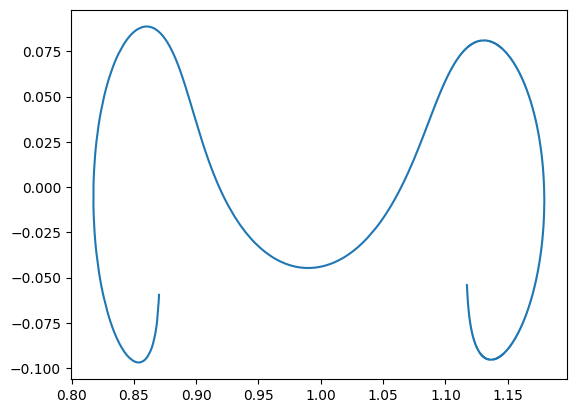

In [14]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [15]:
color2num = dict(
    gray=30,
    red=31,
    green=32,
    yellow=33,
    blue=34,
    magenta=35,
    cyan=36,
    white=37,
    crimson=38
)

def colorize(string, color, bold=False, highlight=False):
    """
    Colorize a string.

    This function was originally written by John Schulman.
    """
    attr = []
    num = color2num[color]
    if highlight: num += 10
    attr.append(str(num))
    if bold: attr.append('1')
    return '\x1b[%sm%s\x1b[0m' % (';'.join(attr), string)

In [16]:
# three body problem env
class ThreeBodyEnv(gym.Env):
    def __init__(self, trajectory_, error_range=0.01, final_range=0.001):
        self.trajectory = trajectory_
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-4, high=4, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory_[0]
        self.steps = 0
        self.max_steps = 20000
        self.final_range = final_range
        self.error_range = error_range
        self.reward_range = (-float('inf'), float('inf'))
        self.render_logic = False
        # second player
        self.second_player = False
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        action = np.clip(action, -self.action_space.high, self.action_space.high)
        # force = action[0] * env.state[2:] + action[1] * env.state[:2]
        a_x = action[0]/100
        a_y = action[1]/100
        # add second player action
        a_x_2 = action[2]/100 if self.second_player else 0
        a_y_2 = action[3]/100 if self.second_player else 0


        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x + a_x_2
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*y/(r2**3) + a_y + a_y_2

        x = x + xdot*self.dt
        y = y + ydot*self.dt

        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        # plot position
        if self.render_logic:
            plt.plot(x, y, 'ro')
            plt.plot(self.trajectory[:,0], self.trajectory[:,1])
            plt.show()

        distance = np.linalg.norm(self.trajectory[:,0:2] - self.position[0:2], axis=1) # just add position and delete velocity
        nearest_idx = np.argmin(distance)
        reward = 100*(1 - np.linalg.norm(self.state, axis=0) - (a_x/10)**2 - (a_y/10)**2 + (a_x_2/10)**2 + (a_y_2/10)**2) - 100
        done = self.steps >= self.max_steps
        # states_array.append(self.state)
        if np.linalg.norm(self.position[0:2] - self.trajectory[-1, 0:2]) < self.final_range:
            done = True
            reward = 1000
            print(colorize("done 🥺", 'green', bold=True))
        if self.steps > self.max_steps:
            done = True
            reward = -1000
            print("end time")
        if self.error_calculation() > self.error_range:
            print(self.state)
            done = True
            reward = -1000 + (nearest_idx/10000)*1000
            print('idx', nearest_idx/100000, 'state', np.linalg.norm(self.state, axis=0))
            print(colorize("too much error 🥲😱", 'red', bold=True))



        # print(self.state, reward, done, self.position)
        return 1000*self.state, reward, done, False, self.position

    def position2state(self):
        # find the nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory[:,0:2] - self.position[0:2], axis=1) # just add position and delete velocity
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
        # self.state = self.state * np.array([10, 10, 1, 1])

    def error_calculation(self):
        normalized_error = self.state * np.array([1, 1, 0.0, 0.0]) # reduce the effect of velocity error
        return np.linalg.norm(normalized_error)

    def reset(self,
              *,
              seed: 5 = None,
              return_info: bool = False,
              options: 6 = None):
        self.position = self.trajectory[0]
        self.steps = 0
        self.position2state()
        return 1000*self.state, {}

[ 0.00560695 -0.00843751  0.04274706 -0.07216529]
idx 0.04766 state 0.08448532425344843
too much error 🥲😱


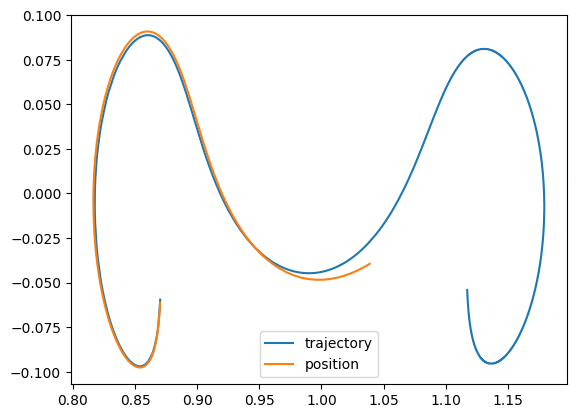

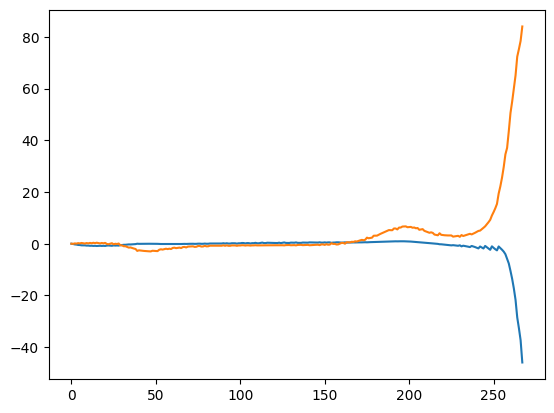

In [17]:
env = ThreeBodyEnv(trajectory)
env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(6000):
    action = -1200 * env.state[2:] - 1 * env.state[:2]
    # print(i)
    # print(action)
    action_array.append(action)
    state, reward, done, _, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legned
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)
